# Master Thesis - Particle Swarm Optimization with constraints - Implementation (Numerical Scheme)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The equations of motion for particle swarm optimization are obtained by adding the interaction, friction, exploration, and constraint terms and this can be written in continuous time formulation as
\begin{equation}
\begin{aligned}
    dX^i(t) &= V^i(t)dt \\
    dV^i(t) &= -\lambda(X^i(t)-\overline{X}(t))dt - \gamma V_i(t)dt+\sigma(t)dB^i(t) +dR(t),
\end{aligned}
\end{equation}
where $dR(t)$ is defined as 
\begin{equation}
    dR(t) = -2\braket{n(X^i(t)),V^i(t)}n(X^i(t))I_{\partial G}(X(t)),
\end{equation}
 $\lambda$ and $\gamma$ are hyper-parameters which will be tested in a range and evaluated using a success rate 
\begin{equation}
    ||X_{min}-X^*|| < 0.2
\end{equation}
Where $X^*$ is the collapsed ensamble value of the positions. Collapsed means that all particles have converged to the same position, which is inevitable if the global minimum has been found due to the interaction term.

To use these SDEs for numerical simulations they have to be rewritten in discrete time formulation. This is done by way of Euler-Maruyama scheme shown in equation to obtain the expression for the position and velocity seen in equation

\begin{equation}
\begin{aligned}
    X_{k+1}^i &= X_k^i + V_k^ih, \\
    V_{k+1}^i &= V_k^i -\lambda(X^i_k-\overline{X}_k)h - \gamma V^i_kh+\sigma_k\sqrt{h}\xi_{k+1}^i+dR_k,
\end{aligned}
\end{equation}
note that $\sigma_k = \sigma(t_k)$, and


In [105]:
T = 5 # Total time
h = 0.01 # time step
N = int(T/h) # number of time steps, 100
N_particles = 100
X = np.zeros((N_particles,2))

In [130]:
def sigma_function(time):
    t_0 = 3
    if time < t_0:
        return 1
    else:
        return 10**(-5)

PSO is driven by SDE that contains four terms: an interaction term that looks like 
\begin{equation}
    -\int_0^t\lambda(X^i(s)-\overline{X}(s))ds,
\end{equation} 
where $X^i(s)$ is the position of a particle, i, at time, t and $\overline{X}(s)$ is a weighted average of all particles at a time t. The weighted average is defined as
\begin{equation}
    \overline{X}(t) = \sum_{j=1}^N \frac{X^j(t)e^{-\alpha U(X^j(t))}}{\sum_{l=1}^Ne^{-\alpha U(X^l(t))}} = \left[\frac{e^{-\alpha U(X^j(t))}}{\sum_{l=1}^Ne^{-\alpha U(X^l(t))}} \equiv w^j\right] = \sum_{j=1}^N X^j(t)w^j,
\end{equation}

In [43]:
def weighted_average(X, alpha, objective_function):
    values = -alpha * objective_function(X)
    clipped_values = np.clip(values, -700, 700)  # Prevent overflow
    exp_values = np.exp(clipped_values)
    total_weight = np.sum(exp_values)
    w = exp_values / total_weight
    w = w.reshape(-1, 1)
    return np.sum(w * X, axis=0)

$dR_k$ is the reflective term in discrete time formulation.

IF $\hat{X}^i_{k+1} \in G^C$:
\begin{equation}
\begin{aligned}
X^i_{\tau,k+1} &= X^i_k+\tau V^i_k \in \partial G, [\tau \in (0,h)] \\
\hat{V}^i_k &= V^i_k -2\braket{ n(X^i_{\tau,k+1}),V^i_k} n(X^i_{\tau,k+1}) \\
X^i_{k+1} &= X^i_{\tau,k+1}+(h-\tau)\hat{V}^i_k
\end{aligned}
\end{equation} 

ELSE:
\begin{equation}
\begin{aligned}
X^i_{k+1} &= \hat{X}^i_{k+1} \\
\hat{V}^i_k &= V^i_k
\end{aligned}
\end{equation}

For this function i need to return $-2\braket{ n(X^i_{\tau,k+1}),V^i_k} n(X^i_{\tau,k+1})$, if $X_{new}$ went into $G^C$, and 0 otherwise

In [76]:
def Reflection_spherical(X_old, V, radius):
    global h
    N_particles = X_old.shape[0]
    X_new = X_old + h * V
    
    # Calculate norms for all particles
    norms = np.linalg.norm(X_new, axis=1)
    
    # Identify particles that need reflection
    reflect_mask = norms > radius
    
    if np.any(reflect_mask):
        a = X_old[reflect_mask]
        b = V[reflect_mask]
        
        # Vectorized calculations
        p = 2 * np.sum(a * b, axis=1) / np.sum(b**2, axis=1)
        q = (np.sum(a**2, axis=1) - radius**2) / np.sum(b**2, axis=1)
        # Add epsilon and use np.maximum to avoid negative values under sqrt
        epsilon = 1e-10
        tau = -p/2 + np.sqrt(np.maximum(p**2/4 - q, epsilon))
        
        X_tau = a + tau[:, np.newaxis] * b
        
        # Calculate outward normals
        outward_normal = X_tau / np.linalg.norm(X_tau, axis=1)[:, np.newaxis]
         #the outward normal is calculated as the normalized position vector of the intersection point X_tau.
        #This works because for a circular (or spherical) boundary centered at the origin, 
        # the outward normal at any point on the boundary is simply the unit vector pointing from the origin to that point.
        
        # Calculate reflected velocities
        V_hat = b - 2 * np.sum(b * outward_normal, axis=1)[:, np.newaxis] * outward_normal
        
        # Update positions for reflected particles
        X_new[reflect_mask] = X_tau + (h - tau[:, np.newaxis]) * V_hat
        V[reflect_mask] = V_hat
    
    return X_new, V


and the iterative update of the discrete velocity is
\begin{equation}
    V^i_{k+1} = \hat{V}^i_k -\lambda(X^i_{k+1}-\overline{X}_{k+1})h - \gamma \hat{V}^i_k h + \sigma_k\xi^i_{k+1}\sqrt{h}.
\end{equation}

In [48]:
def PSO(X_old, V_old,alpha,objective_function, Lambda, gamma, sigma,radius):
    # X: particle positions
    # weighted_average_X: weighted average of particle positions
    # V: particle velocities
    # Lambda: interaction coefficient
    # gamma: inertia coefficient
    # sigma: exploration coefficient
    # returns updated X, weighted_average_X, V
    N_particles = X_old.shape[0]

    global h
    weighted_average_X_old = weighted_average(X_old,alpha,objective_function)
    X_hat, V_hat = Reflection_spherical(X_old,V_old,radius)
    X_new = X_hat
    weighted_average_X = weighted_average(X_new,alpha,objective_function)
    V_new = V_hat - Lambda*(X_new-weighted_average_X)*h-gamma*V_hat*h+sigma*np.sqrt(h)*np.random.randn(N_particles,1)
    
    return X_new, V_new

# Benchmark functions to test method on:
- Eggholder function, global minima located at ${\displaystyle f(512,404.2319)=-959.6407}$
- Cross-In-Tray function 4 global minima located at ${\displaystyle {\text{Min}}={\begin{cases}f\left(1.34941,-1.34941\right)&=-2.06261\\f\left(1.34941,1.34941\right)&=-2.06261\\f\left(-1.34941,1.34941\right)&=-2.06261\\f\left(-1.34941,-1.34941\right)&=-2.06261\\\end{cases}}}$

For Eggholder case the radius used in reflection_spherical must be larger than the distance to where the global minima is located, which is $\approx 653$, meaning a radius of 700 will work fine.

For cross-in-tray function the minimas are located at a distance of $\approx 1.91$ from origin which means a radius of 2 will be employed. 

In [50]:
def egg_holder(X):
    x = np.clip(X[:,0], -512, 512)
    y = np.clip(X[:,1], -512, 512)
    return -(y+47)*np.sin(np.sqrt(np.abs(x/2+(y+47))))-x*np.sin(np.sqrt(np.abs(x-(y+47))))


In [9]:
def cross_in_tray(X):
    x = X[:,0]
    y = X[:,1]
    return -0.0001*(np.abs(np.sin(x)*np.sin(y)*np.exp(np.abs(100-np.sqrt(x**2+y**2)/np.pi)))+1)**0.1

In [ ]:
#Grid search for optimal parameters
alpha = 10
Lambda = 0.5
gamma = 0.1

radius = 1000

objective_function = egg_holder

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
best_min = np.inf
time = 0

for lambda_ in np.linspace(0.1,10,10):
    for gamma_ in np.linspace(0.1,1,10):
        Lambda = lambda_
        gamma = gamma_
        time = 0
        particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
        particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
        while time<T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,radius)
            time += h
        if np.min(objective_function(particle_positions_X)) < best_min:
            best_min = np.min(objective_function(particle_positions_X))
            print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
            plt.plot(particle_positions_X[:,0],particle_positions_X[:,1],'o')
            plt.xlim(-1000,1000)
            plt.ylim(-1000,1000)
            plt.show()


alpha:  10 Lambda:  5 gamma:  1 objective:  -873.5618485424121
alpha:  10 Lambda:  5 gamma:  1 objective:  -875.3854998762138
alpha:  10 Lambda:  5 gamma:  1 objective:  -882.0898102942938
alpha:  10 Lambda:  5 gamma:  1 objective:  -891.4736930611905
alpha:  10 Lambda:  5 gamma:  1 objective:  -902.9608689576719
alpha:  10 Lambda:  5 gamma:  1 objective:  -915.857383024869
alpha:  10 Lambda:  5 gamma:  1 objective:  -929.159933990471
alpha:  10 Lambda:  5 gamma:  1 objective:  -941.5294138470817
alpha:  10 Lambda:  5 gamma:  1 objective:  -951.1940273505588
alpha:  10 Lambda:  5 gamma:  1 objective:  -955.8600529761607
alpha:  10 Lambda:  5 gamma:  1 objective:  -952.3898447851413
alpha:  10 Lambda:  5 gamma:  1 objective:  -936.2462909274328
alpha:  10 Lambda:  5 gamma:  1 objective:  -900.3174287559422
alpha:  10 Lambda:  5 gamma:  1 objective:  -831.2772730714956
alpha:  10 Lambda:  5 gamma:  1 objective:  -821.3320974598464
alpha:  10 Lambda:  5 gamma:  1 objective:  -829.28221638

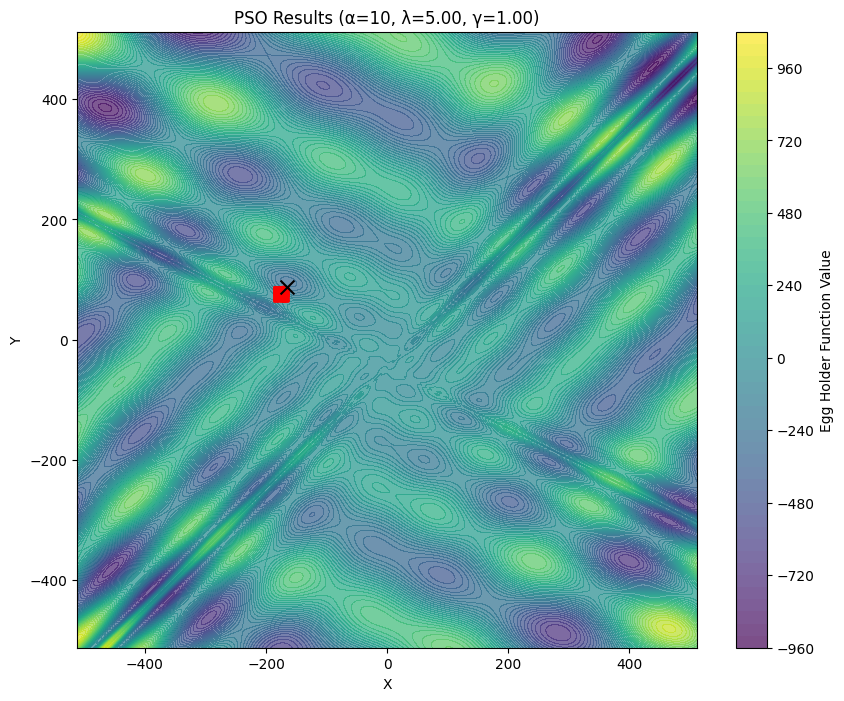

In [168]:
#Grid search for optimal parameters
alpha = 10
Lambda = 5
gamma = 1
N_particles = 1000
radius = 700

objective_function = egg_holder

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-512, 512, 1000)
y = np.linspace(-512, 512, 1000)
X, Y = np.meshgrid(x, y)
Z = egg_holder(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)
plt.figure(figsize=(10, 8))
# Plotting

plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(label='Egg Holder Function Value')
plt.xlim(-512, 512)
plt.ylim(-512, 512)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f})')
while time<T:
    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,radius)
    print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
    time += h 

min_index = np.argmin(objective_function(particle_positions_X))
min_x, min_y = particle_positions_X[min_index]
plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1, alpha=0.5)
plt.scatter(min_x, min_y, color='black', s=100, zorder=5, marker='x')
print(min_x, min_y, objective_function(particle_positions_X)[min_index])


alpha:  10 Lambda:  5 gamma:  1 objective:  -2.023131517365636
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0227710446893443
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0226093975169834
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.022187231288377
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.021474746868878
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0208667617327807
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.02035762004335
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0200449854243003
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0196985767261864
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0196492333040057
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.019831773386951
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0198125136441374
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0196816333597267
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.019783609926818
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.0206676499686482
alpha:  10 Lambda:  5 gamma:  1 objective:  -2.

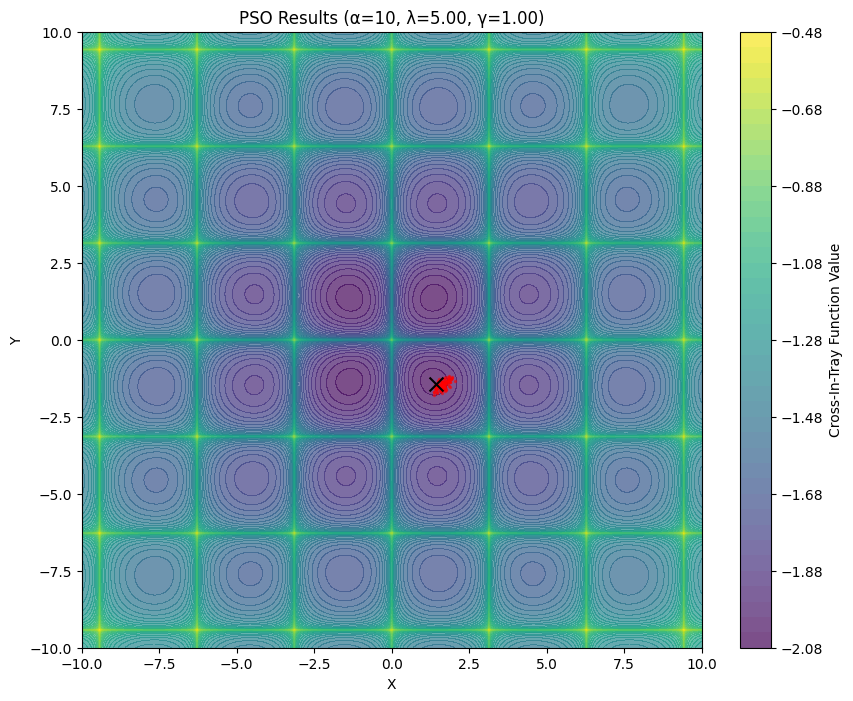

In [162]:
#Grid search for optimal parameters
alpha = 10
Lambda = 5
gamma = 1

radius = 10

objective_function = cross_in_tray

particle_positions_X = np.random.uniform(-7,7,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)
plt.figure(figsize=(10, 8))
# Plotting
#plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1.5, alpha=0.5)
plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cross-In-Tray Function Value')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f})')
while time<T:
    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,radius)
    print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
    time += h 

min_index = np.argmin(objective_function(particle_positions_X))
min_x, min_y = particle_positions_X[min_index]
plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1.5, alpha=0.5)
plt.scatter(min_x, min_y, color='black', s=100, zorder=5, marker='x')
print(min_x, min_y, objective_function(particle_positions_X)[min_index])


In [50]:
print(norms)

[521.98431328 310.12592805 564.32354604 310.35506764 201.04620394
 176.73815224 385.28970306 403.53389429 575.94802317  57.25246276
 309.77639849 393.63486011 529.82470819 338.28311416 628.8875259
 398.3986359  540.99726669 402.64403802 318.73168545 364.20662202
 552.9946539  341.63740612 529.37336201 381.3411366  461.54103183
 379.38576744 178.31372698 439.59433085 427.00171747 412.38744952
 429.47991426 116.82875335 445.07771336  12.03796951 253.50990402
 212.62225711  32.2301072  556.19267426 108.91462426 430.47194857
 566.61406215 392.89089969 450.63216333 494.38791404 486.78144239
 402.12336499 586.29024798 433.15678122 237.37127941 512.92950693
 418.7577497  400.96723439 572.24021665 580.95127212 484.13854464
 100.10650521 436.3597098  452.72537923 499.01835549 187.91861911
 389.38050851 273.26822471 301.8097858  409.65317082  57.03150894
 244.81520447 393.32995665 202.18906181 474.60035351 244.09583642
 466.59438648 306.9641225   45.34357367 213.85550603 148.23785038
 475.577264